In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (15, 9)


from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, hp, tpe, STATUS_OK
from hyperopt.pyll.base import scope
from typing import Callable

In [2]:
train_raw = pd.read_csv('data/train.csv', dtype=float)
test = pd.read_csv('data/test.csv', dtype=float)

Need to downsample the data, otherwise it will be impossible to show.

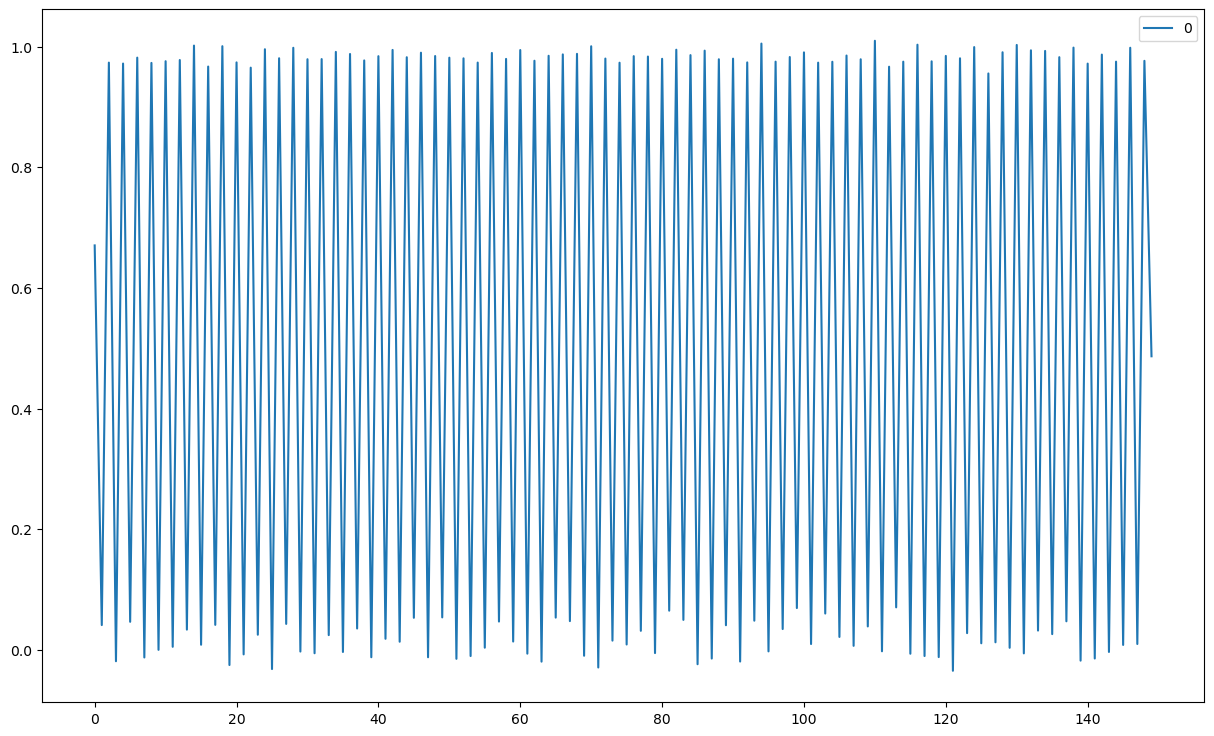

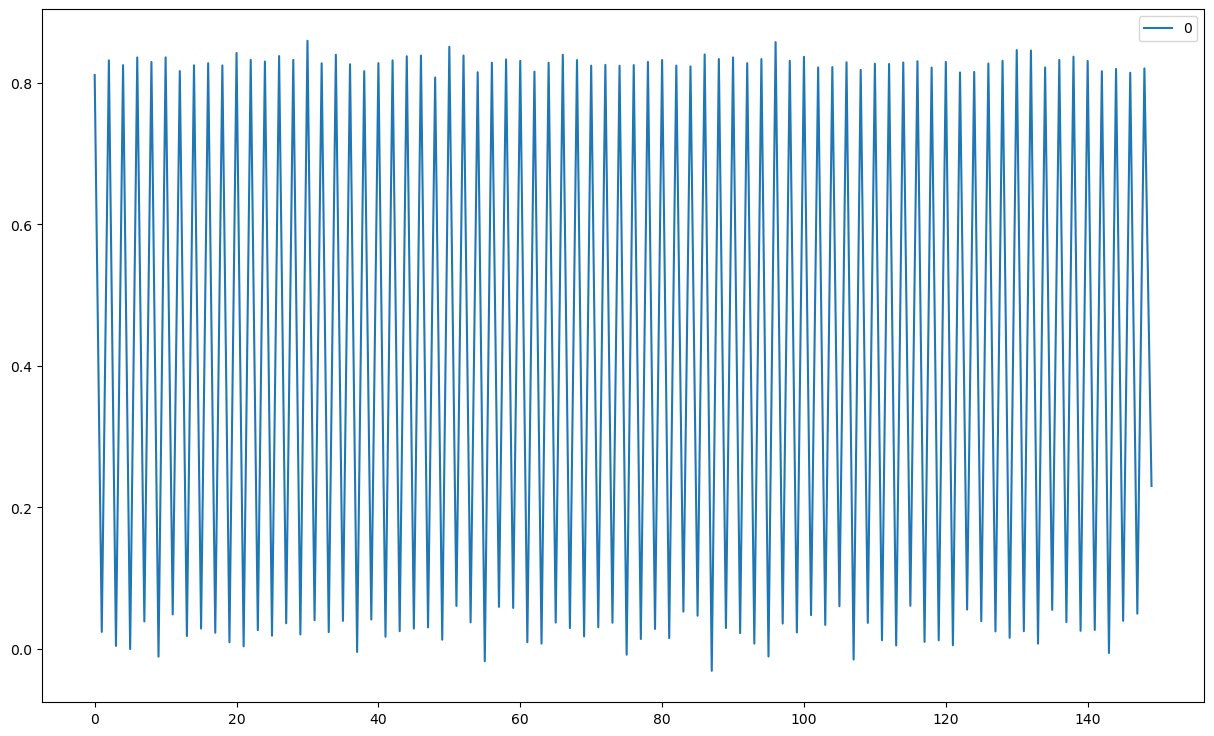

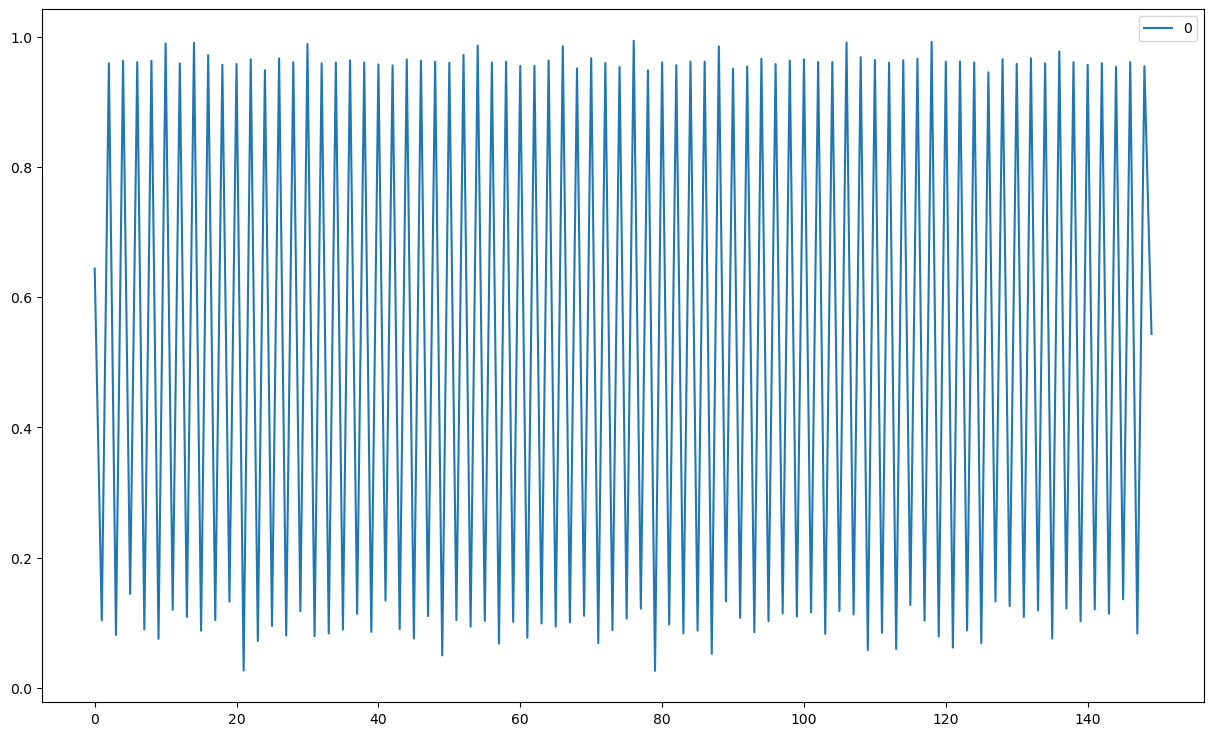

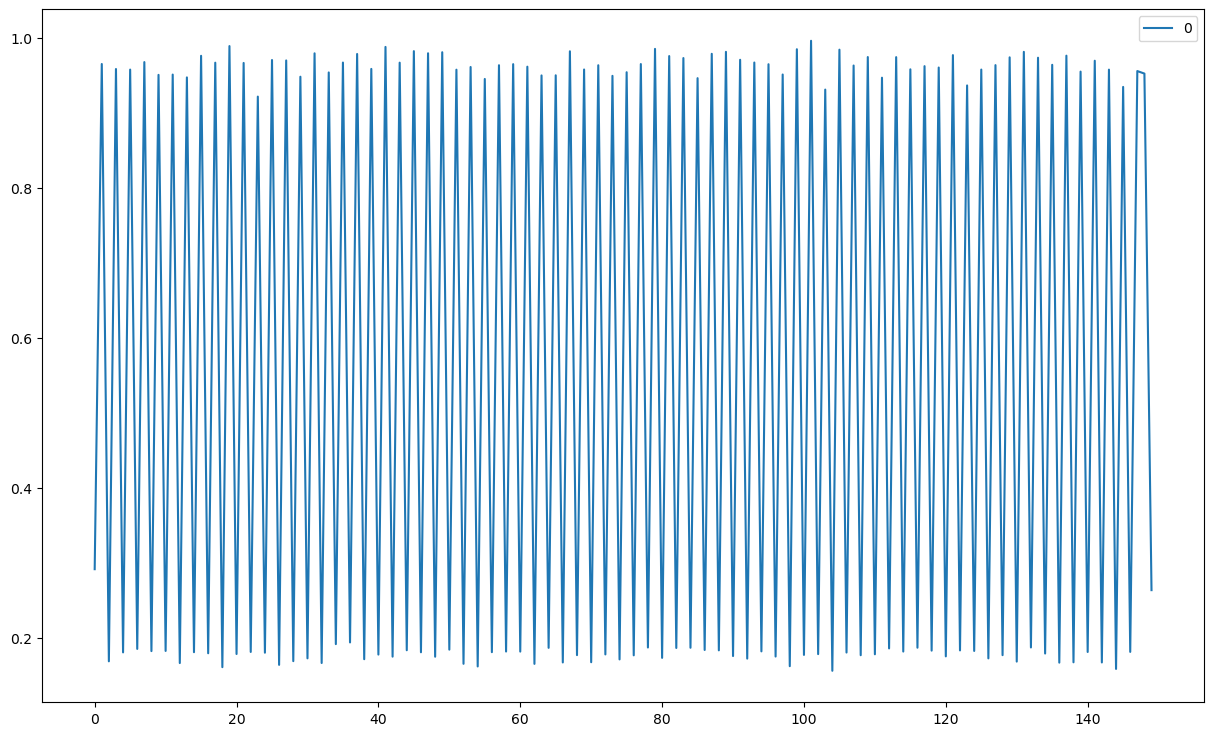

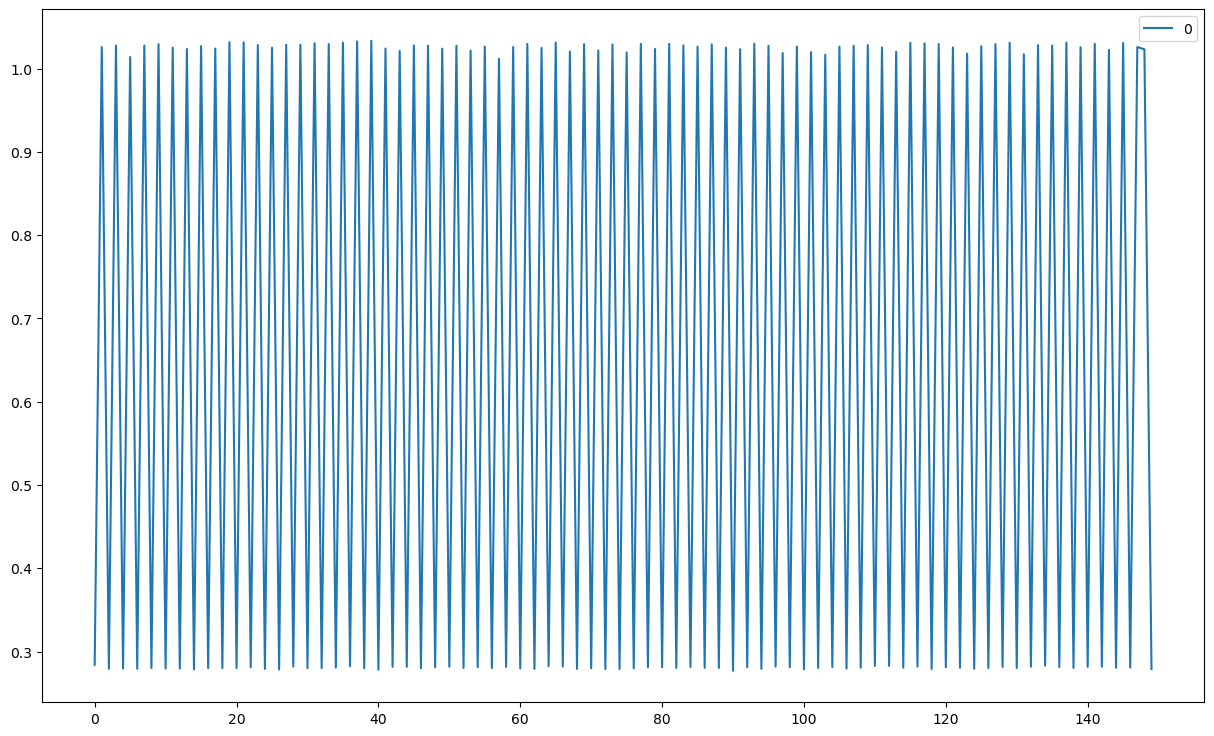

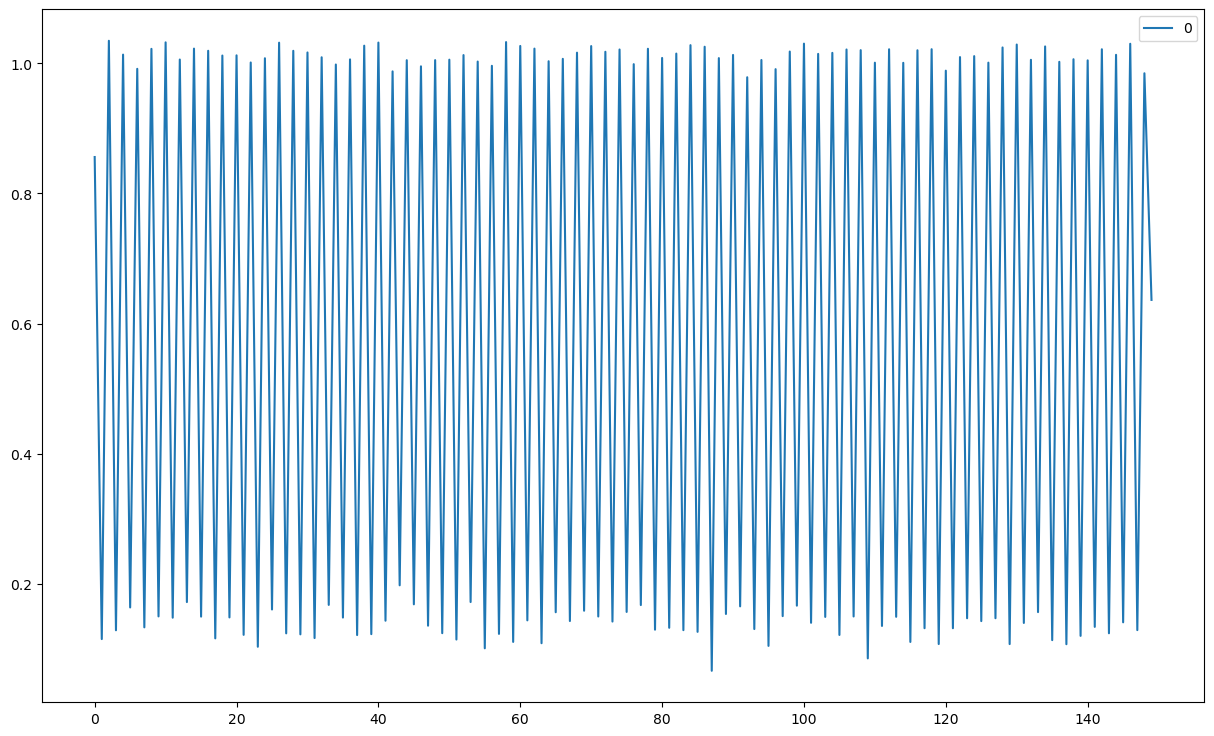

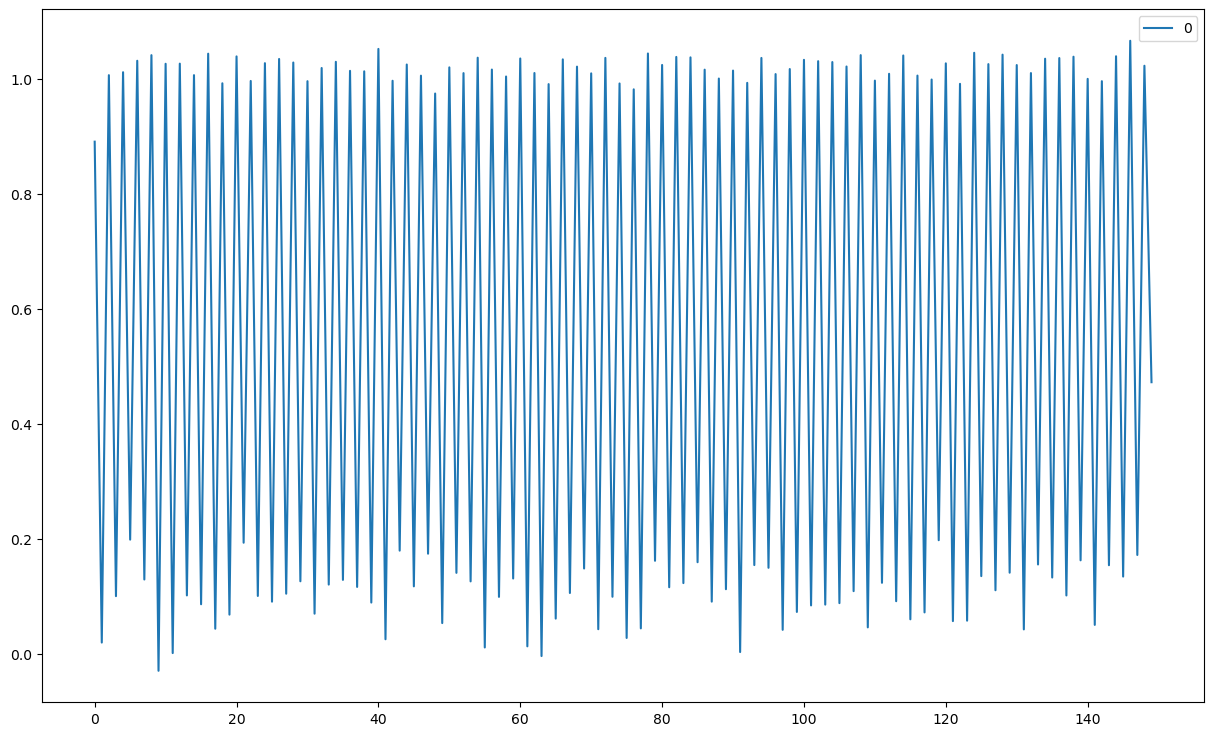

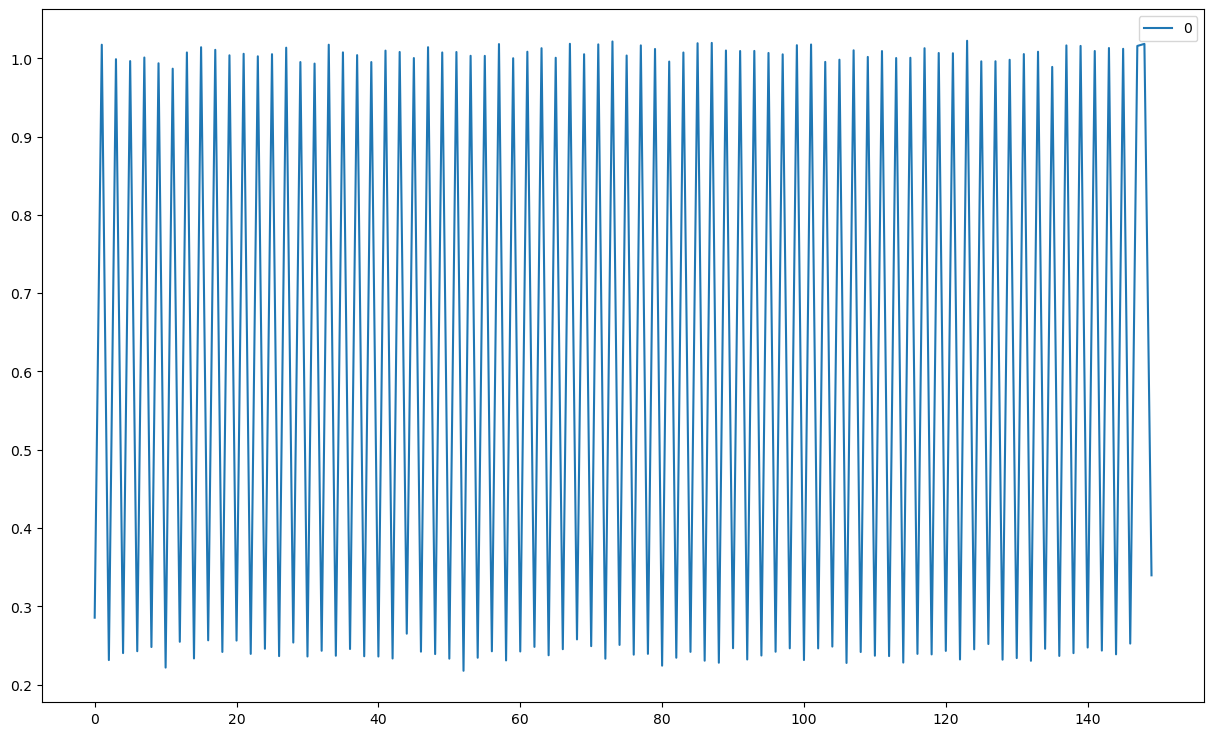

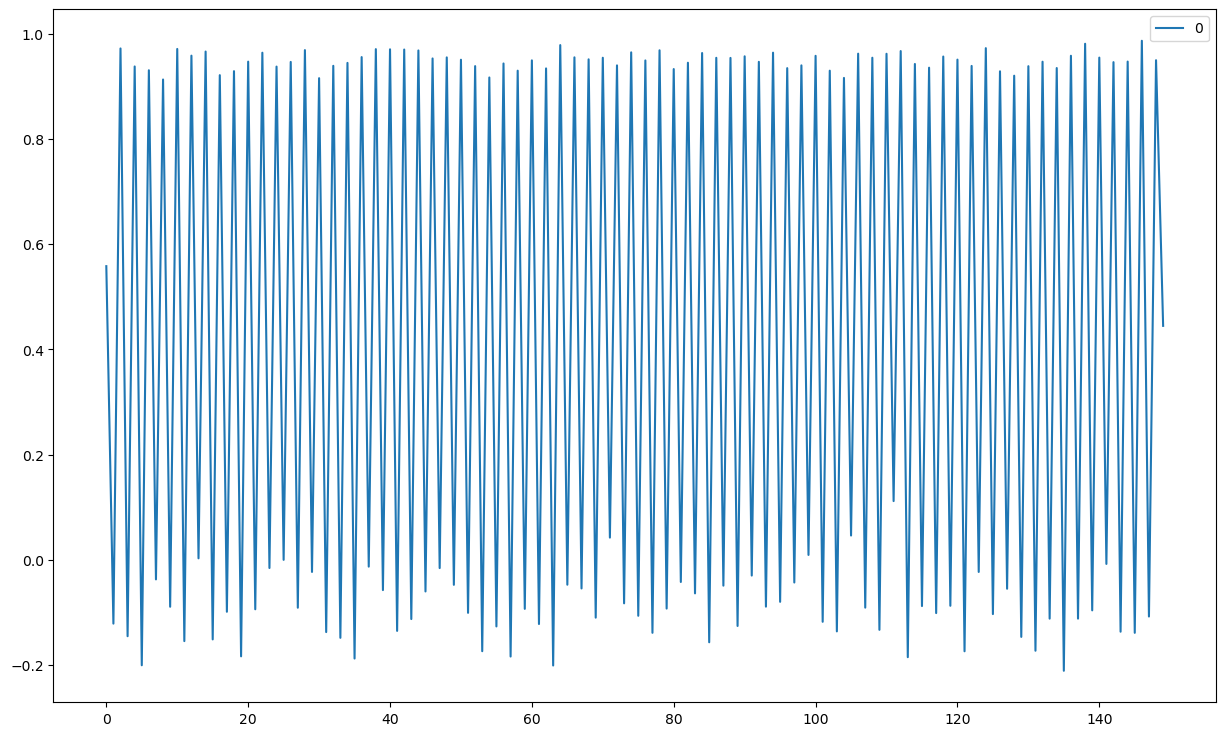

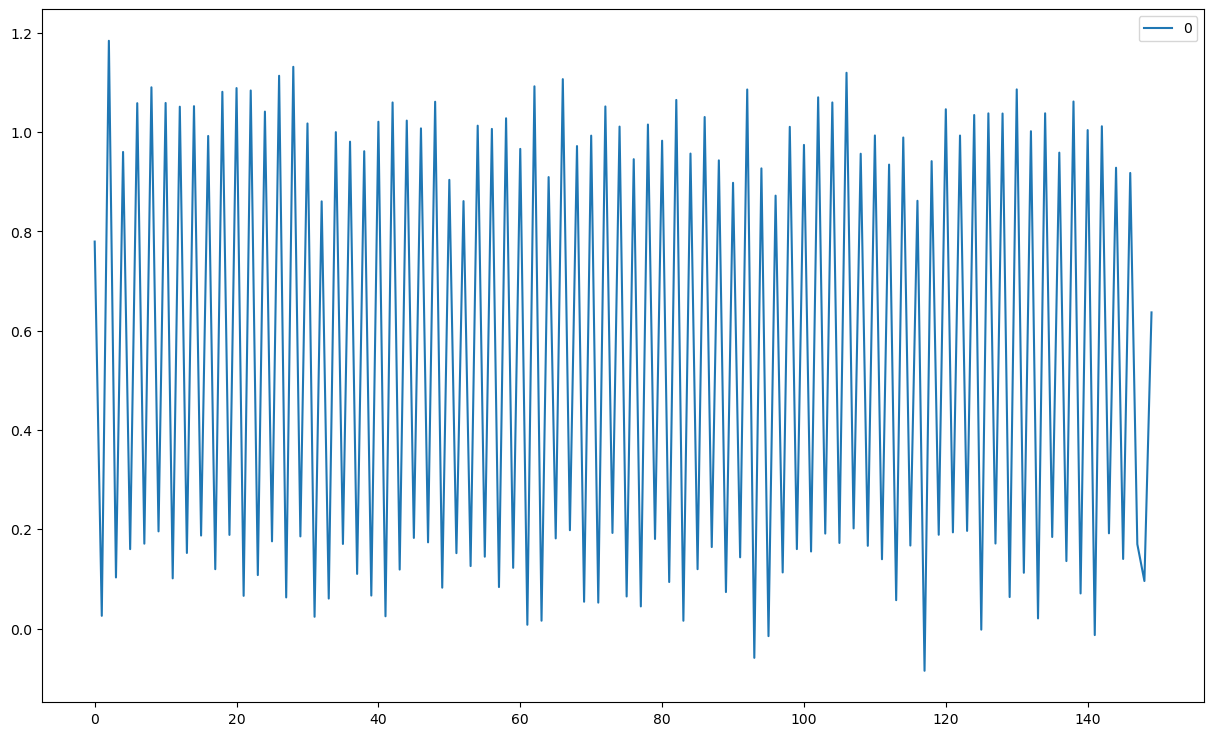

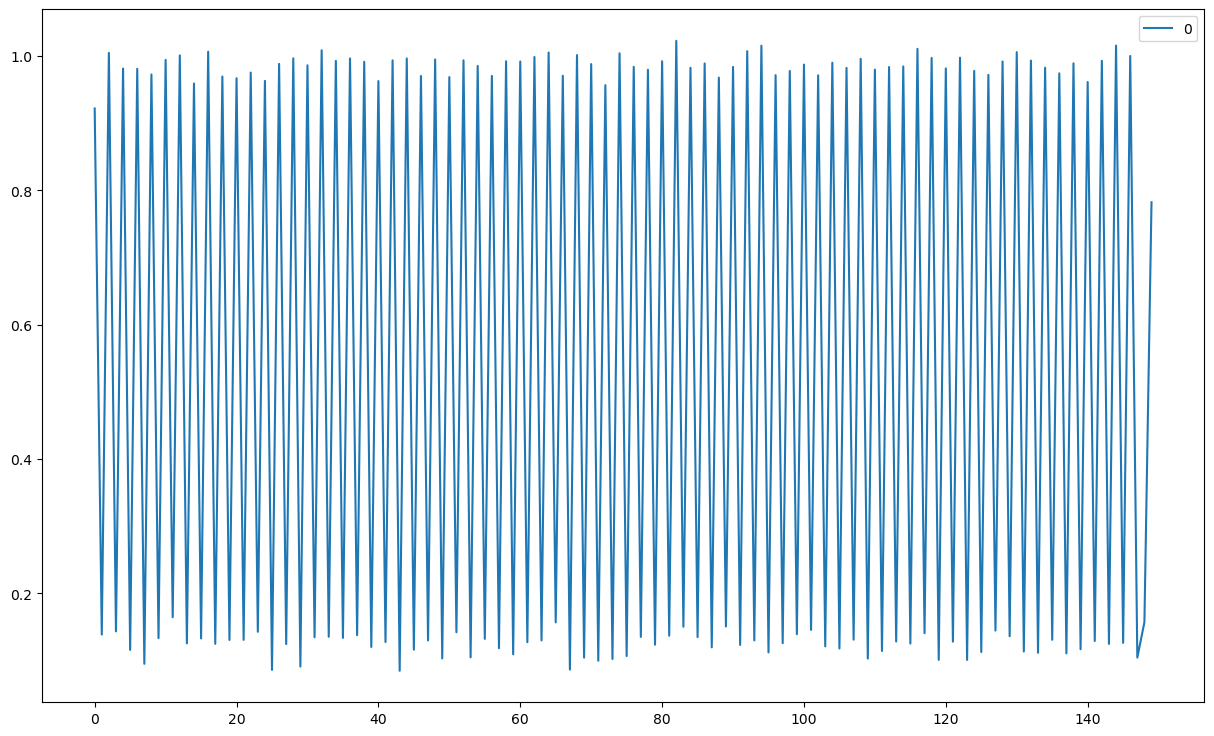

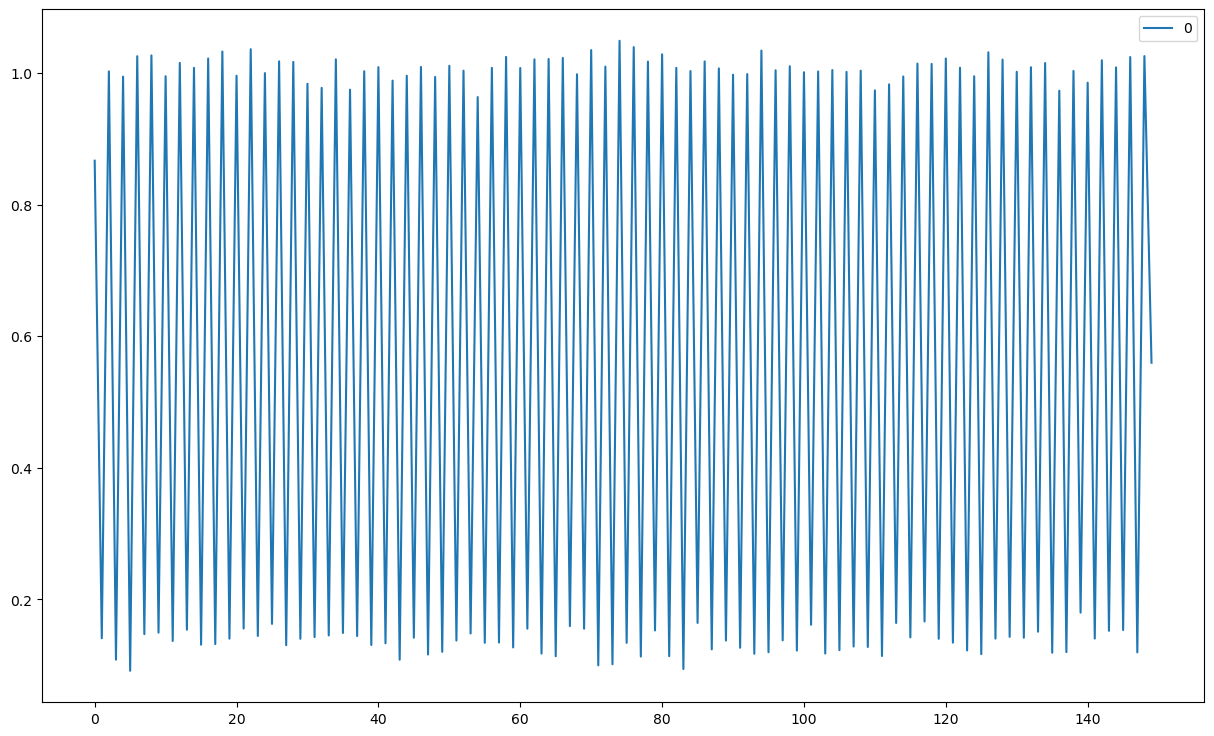

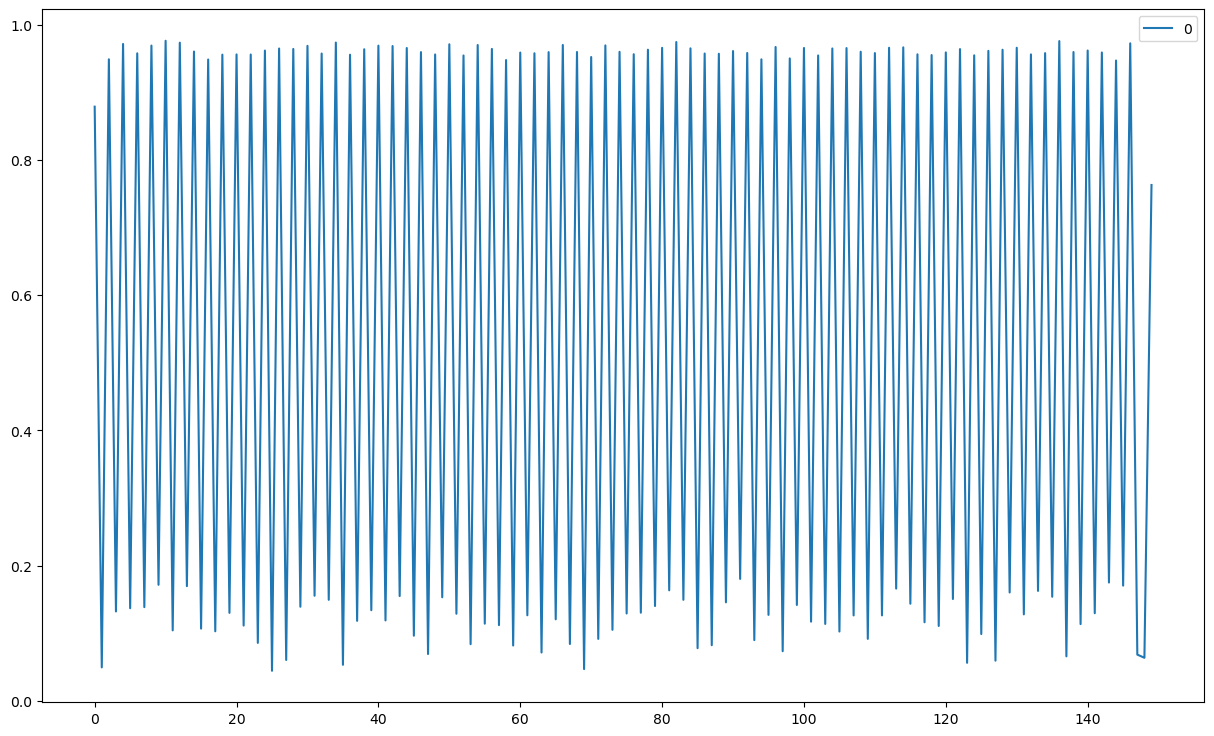

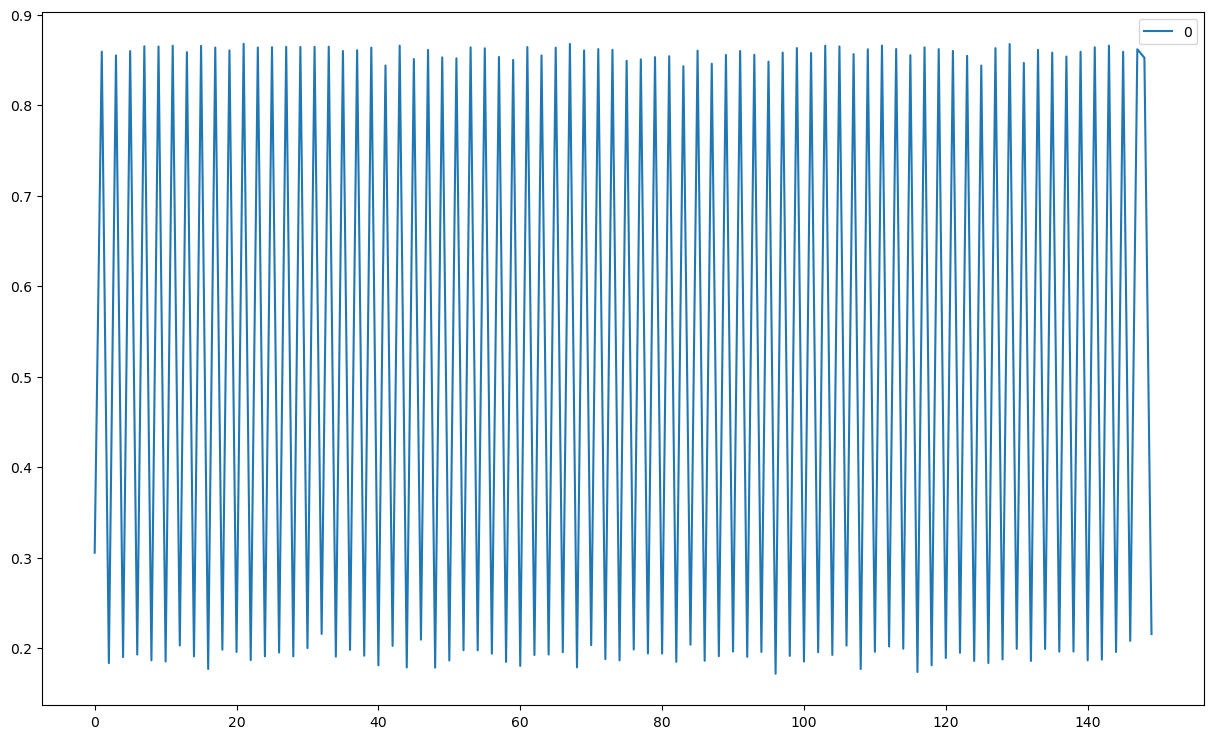

In [3]:
import lttb

relevant_data = train_raw.drop('target', axis=1)

for cnt in range(14):
    frame = pd.DataFrame([
        relevant_data.loc[:, 'id'].to_numpy(),
        relevant_data.loc[:, f'cont{cnt + 1}'].to_numpy()
    ])
    np_array = frame.to_numpy().T
    data_downsampled = lttb.downsample(np_array, n_out=int(np_array.shape[0] * .0005))

    pd.DataFrame(data_downsampled[:, 1]).plot.line(subplots=True)
    plt.show()

Using downsampling threshold varying from .0002 to .001 the data looks like some kind of oscillation data with a small degree of noise. Let's downsample the dataset one more time using a higher threshold and keep the target column - also downsampled - and train models on that.

In [4]:
THRESHOLD = .005

data_with_target = train_raw.loc[:, ['id', 'target']].to_numpy()
target_downsampled = lttb.downsample(data_with_target, n_out=int(data_with_target.shape[0] * THRESHOLD))
data_without_target = train_raw.drop(['target'], axis=1)
data_without_target_downsampled = []

for cnt in range(14):
    np_array = pd.DataFrame([
        data_without_target.loc[:, 'id'].to_numpy(),
        data_without_target.loc[:, f'cont{cnt + 1}'].to_numpy()
    ]).to_numpy().T
    data_downsampled = lttb.downsample(np_array, n_out=int(np_array.shape[0] * THRESHOLD))

    if cnt == 0:
        data_without_target_downsampled.append(data_downsampled[:, 0])

    data_without_target_downsampled.append(data_downsampled[:, 1])

In [5]:
all_data_downsampled = np.array(data_without_target_downsampled).T
all_data_downsampled = np.c_[all_data_downsampled, target_downsampled[:, 1]]

In [8]:
X_train = all_data_downsampled[:1000, 1:15]
y_train = all_data_downsampled[:1000, 15:].ravel()
X_valid = all_data_downsampled[1000:, 1:15]
y_valid = all_data_downsampled[1000:, 15:].ravel()


def svr_objective(search_space: dict) -> dict:
    search_space['C'] = float(search_space['C'])

    regressor = SVR(**search_space)

    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_valid)
    accuracy = mean_squared_error(y_valid, y_pred)

    return {'loss': accuracy, 'status': STATUS_OK}

In [3]:
def find_params(search_space: dict, get_objective: Callable) -> dict:
    algorithm = tpe.suggest
    best_params = fmin(
        fn=get_objective,
        space=search_space,
        algo=algorithm,
        max_evals=100)

    return best_params

In [9]:
svr_params = find_params({
    'kernel': hp.choice('kernel', ('rbf', 'poly')),
    'degree': hp.randint('degree', 9),
    'C': scope.int(hp.uniform('C', 1, 10)),
    'gamma': scope.int(hp.uniform('gamma', 0, 10))
}, svr_objective)

100%|██████████| 100/100 [06:57<00:00,  4.17s/trial, best loss: 3.8902923932275115]


In [4]:
import xgboost as xgb


train_raw_xgb = train_raw.drop('id', axis=1).to_numpy()
split = int(train_raw_xgb.shape[0] * .7)
X_train_xgb = train_raw_xgb[:split, :14]
y_train_xgb = train_raw_xgb[:split, 14:]
X_valid_xgb = train_raw_xgb[split:, :14]
y_valid_xgb = train_raw_xgb[split:, 14:]


def xgb_objective(search_space: dict) -> dict:
    regressor = xgb.XGBRegressor(**search_space)

    regressor.fit(X_train_xgb, y_train_xgb)

    y_pred = regressor.predict(X_valid_xgb)
    accuracy = mean_squared_error(y_valid_xgb, y_pred)

    return {'loss': accuracy, 'status': STATUS_OK}

In [5]:
xgb_params = find_params({
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'gamma': hp.uniform ('gamma', 0, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
    'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
    'learning_rate': hp.uniform('learning_rate', 0, .15),
    'random_state': 5,
    'max_bin' : scope.int(hp.quniform('max_bin', 200, 550, 1))}, xgb_objective)

100%|██████████| 100/100 [19:24<00:00, 11.65s/trial, best loss: 0.4904948875741196]


In [6]:
regressor = xgb.XGBRegressor(
    colsample_bytree=0.7446950226284034,
    gamma=0.697776868966826,
    learning_rate=0.11205606010503663,
    max_bin=538,
    max_depth=9,
    min_child_weight=2.1057925465153993)

regressor.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7446950226284034, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.697776868966826, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.11205606010503663, max_bin=538,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=2.1057925465153993, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

In [7]:
y_pred = regressor.predict(X_valid_xgb)

mean_squared_error(y_valid_xgb, y_pred)

0.49144389647790976

In [8]:
X_test = test.drop('id', axis=1).to_numpy()
y_test = regressor.predict(X_test)

In [14]:
import os


pd\
    .DataFrame(np.column_stack([test.loc[:, 'id'], y_test]), columns=['id', 'target'])\
    .astype({'id': int})\
    .to_csv(os.path.join('submissions', 'classic.csv'), index=False)